# Bibliotheken

In [1]:
import numpy as np # lineare Algebra
import pandas as pd # Datenverarbeitung
import matplotlib.pyplot as plt    #für Plots
import seaborn as sns # Datenvisualisierung baut auf Matplotlib auf
import plotly.express as px #für Korrelationsmatrix
import time
import optuna

# Sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


#Modelle
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [2]:
print('Jupyter Version:')
!jupyter notebook --version

Jupyter Version:
6.5.4


# Datenvorbereitung
### Daten Laden

In [3]:
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')
submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

In [4]:
train.head() # Ausgabe erszen 5 Zeilen

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
print('Trainingsdatensatz Zeilen, Spalten:', train.shape)
print('Testdatensatz Zeilen, Spalten:', test.shape)

Trainingsdatensatz Zeilen, Spalten: (8693, 14)
Testdatensatz Zeilen, Spalten: (4277, 13)


In [6]:
train['HomePlanet'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: HomePlanet
Non-Null Count  Dtype 
--------------  ----- 
8492 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB


### Beschreibung der Spalten:

- **PassengerId**: A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### Missing Values

In [7]:
print('Trainingsdatensatz Missing Values:')
print(train.isna().sum().sort_values(ascending = False))
print('')
print('Testdatensatz Missing Values:')
print(test.isna().sum().sort_values(ascending = False))

Trainingsdatensatz Missing Values:
CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

Testdatensatz Missing Values:
FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


Text(0.5, 1.0, 'Heatmap der Missing Values')

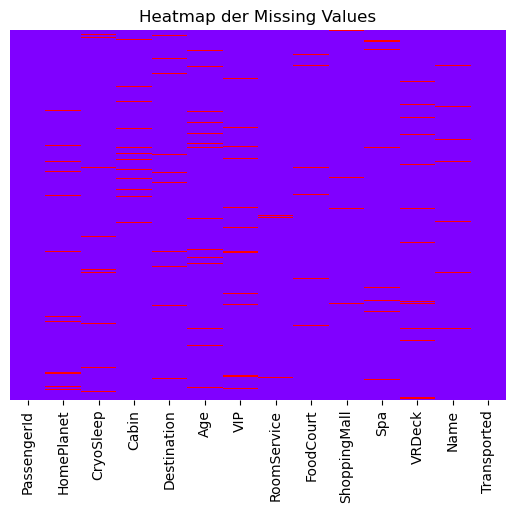

In [8]:
sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = 'rainbow')
plt.title('Heatmap der Missing Values')

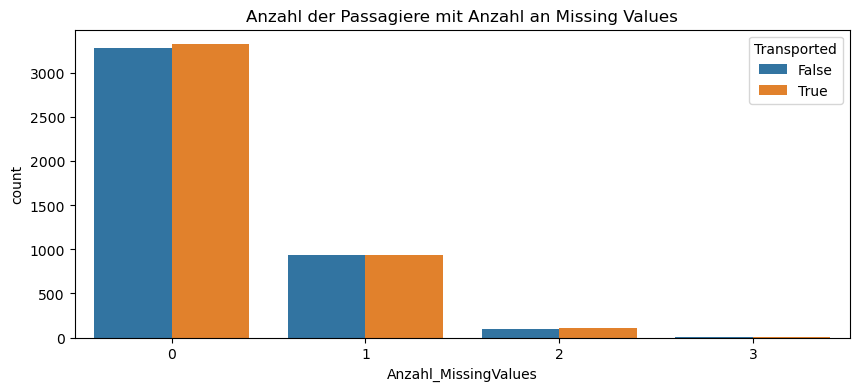

In [9]:
# Zählt die Passagiere mit 0 , 1, 2, 3 Missing Values
train['Anzahl_MissingValues']=train.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Anzahl_MissingValues', hue='Transported')
plt.title('Anzahl der Passagiere mit Anzahl an Missing Values')
train.drop('Anzahl_MissingValues', axis=1, inplace=True)

##### Notiz: 
- Die meisten Passagiere haben keine Missing Values. Wobei es aber immerhin einen nicht zu vernächlässigen Anteil mit 1 Missing Value gibt.
- PassengerID und Transported haben keine missing Values
- Die Verteilung auf der Heatmap ist relativ ausgeglichen.

### Duplikate

In [10]:
print(f'Duplikate in Trainingsdatensatz: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print('')
print(f'Duplikate in Testdatensatz: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')

Duplikate in Trainingsdatensatz: 0, (0.0%)

Duplikate in Testdatensatz: 0, (0.0%)


### Mächtigkeit (Anzahl verschiedener Werte) und Datentypen

In [11]:
print('Mächtigkeit:')
train.nunique()

Mächtigkeit:


PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [12]:
print('Datentypen:')
train.dtypes

Datentypen:


PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [13]:
print('Beschreibung der Float-Daten:')
print('')
train.describe() 

Beschreibung der Float-Daten:



,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


# Untersuchen und Visualisieren der Daten

### Zielvariable (Transported)

Text(0.5, 1.0, 'Verteilung Zielvariable')

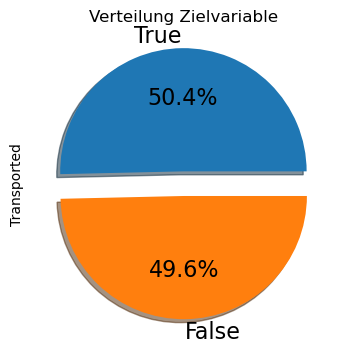

In [14]:
# Figure size
plt.figure(figsize=(4,4))

# Pie plot
train['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Verteilung Zielvariable")


##### Notiz: 
Die Verteilung der Zielvariable ist sehr ausgeglichen.

## Kontinuierliche Merkmale
### Age

Text(0.5, 0, 'Age (years)')

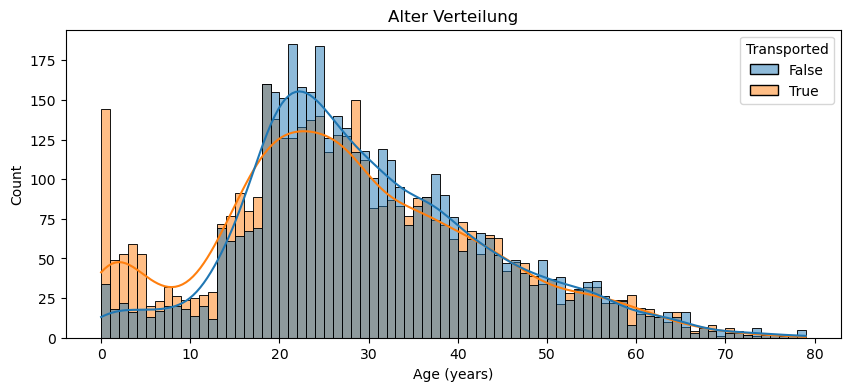

In [15]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Alter Verteilung')
plt.xlabel('Age (years)')

##### Notiz: 
Es fällt auf, dass die jüngeren Passagiere tendenziell häufiger transportiert wurden.

### RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

#### Verteilung abhängig von der Zielvariable

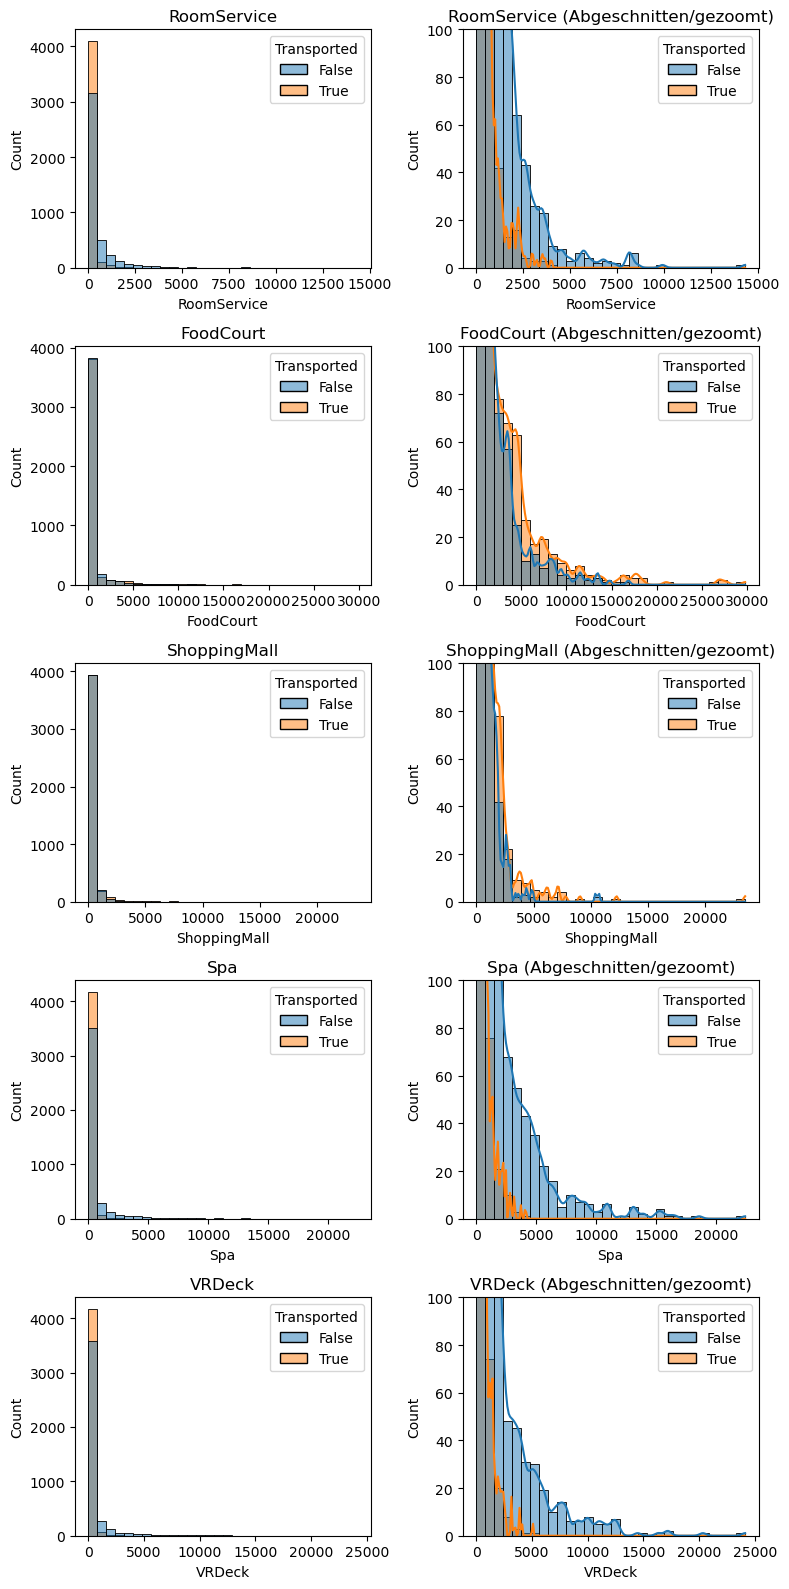

In [16]:
#Ausgabemerkmale
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot
fig=plt.figure(figsize=(8,16))
for i, var_name in enumerate(exp_feats):
    # Linker plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)

    
    # Rechter plot (abgeschnitten)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    #ax.set_title(var_name)
    ax.set_title(f"{var_name} (Abgeschnitten/gezoomt)")  
    
fig.tight_layout()  # Verbessert das Aussehen ein wenig
plt.show()

##### Notiz: 
- Die meisten Leute haben kein Geld für die entsprechenden Luxusgüter ausgegeben
- Tendenzell haben die leute die Transportiert wurden eher weniger/nichts für Luxusgüter ausgegeben

#### Korrelationsmatrix

In [17]:
fig = px.imshow(train.corr(numeric_only=True) ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.show()

##### Notiz: 
Umso höher der Wert an 1 oder -1, desto mehr korellieren die beiden Merkmale miteinander.

## Kategorische Merkmale
(Die Merkmale, welche sich in eine überschaubare Anzahl Kategorien unterteilen lassen)

### Verteilung der Kategorischen Merkmale

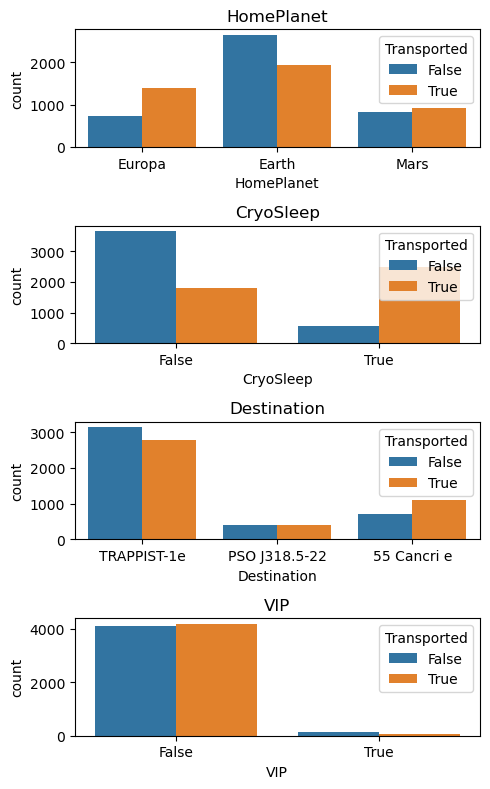

In [18]:
# Kategorische Merkmale
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

#Kategorischen Merkmale plotten
fig=plt.figure(figsize=(5,8))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Verbessert Aussehen bisschen
plt.show()

##### Notiz: 
- Die Passagiere aus Europa wurden häufiger transportiert als nicht transportiert
- Bei Erde als Home-Planet eher anders herum
- Bei CryoSleep = TRUE bestet eine sehr hohe Korellation mit der Zielvariable

## Textmerkmale
Diese müssen später erst noch überarbeitet werden um sie effektiv nutzen zu können.

In [19]:
# Textmerkmale
qual_feats=['PassengerId', 'Cabin' ,'Name']

# Übersicht Textmerkmale
train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


#### Notiz:
- PassengerId hat die Form gggg_pp, wobei gggg die Gruppe angibt, mit der der Passagier reist, und pp seine Nummer innerhalb der Gruppe ist.
- Die Kabinennummer hat die Form Deck/Nummer/Seite, wobei Seite entweder P für Backbord oder S für Steuerbord sein kann.

# Feature Engineering
## Alter Gruppieren
Alter wird zusätzlich in Gruppen eingeteilt. Dies kann hilfreich sein, um fehlende Werte später aufzufüllen.

Text(0.5, 1.0, 'Verteilung Altersgruppen')

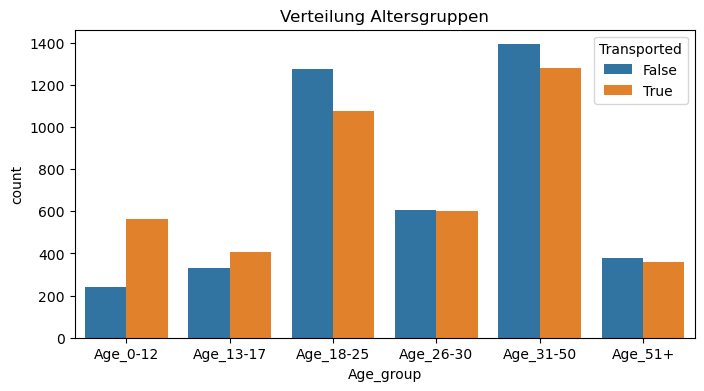

In [20]:
# Neue features - trainingsdaten
train['Age_group']=np.nan #neue Spalte
train.loc[train['Age']<=12,'Age_group']='Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group']='Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group']='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group']='Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group']='Age_31-50'
train.loc[train['Age']>50,'Age_group']='Age_51+'

# Neue features - testdaten
test['Age_group']=np.nan #neue Spalte
test.loc[test['Age']<=12,'Age_group']='Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18),'Age_group']='Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25),'Age_group']='Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30),'Age_group']='Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50),'Age_group']='Age_31-50'
test.loc[test['Age']>50,'Age_group']='Age_51+'

# neues Feature Plotten
plt.figure(figsize=(8,4))
g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Verteilung Altersgruppen')

#train.drop('Age_group', axis=1, inplace=True)
#test.drop('Age_group', axis=1, inplace=True)

## Ausgaben
Es wird ein neues Feature erzeugt, wo alle Ausgaben einer Person zusammengezählt werden. Außerdem gibt es ein neues binäres Feature wo angibt ob Ausgaben getätigt wurden oder nicht.

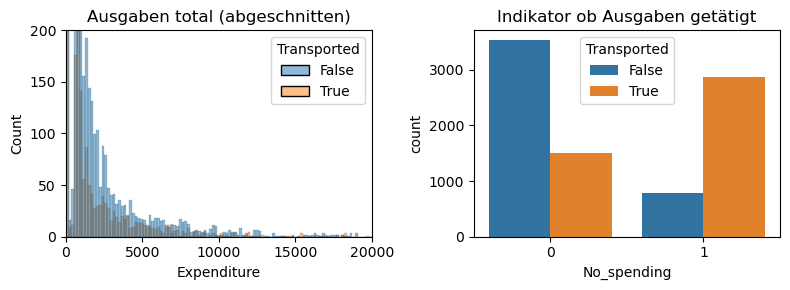

In [21]:
# Neue features - trainingsdaten
train['Expenditure']=train[exp_feats].sum(axis=1)
train['No_spending']=(train['Expenditure']==0).astype(int)

# Neue features - testdaten
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

# neue Features Plotten
fig=plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Ausgaben total (abgeschnitten)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('Indikator ob Ausgaben getätigt')
fig.tight_layout()

Notiz:
- Auffällig ist, dass es eine hohe Korellation mit der Zielvariablen und No_Spending gibt

## Gruppengröße und Gruppe
Es werden zwei Features aus der PassenderId erzeugt. Die Gruppennummer und die Gruppengröße. Um das Ergebniss so wenig wie möglich zu verfälschen können wir für die Gruppengröße die Trainings und die Testdaten verwenden. Es könnte ja sein, dass zwei Leute einer Gruppe in den Trainingsdaten und die anderen 3 in den Testdaten gelistet sind.

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



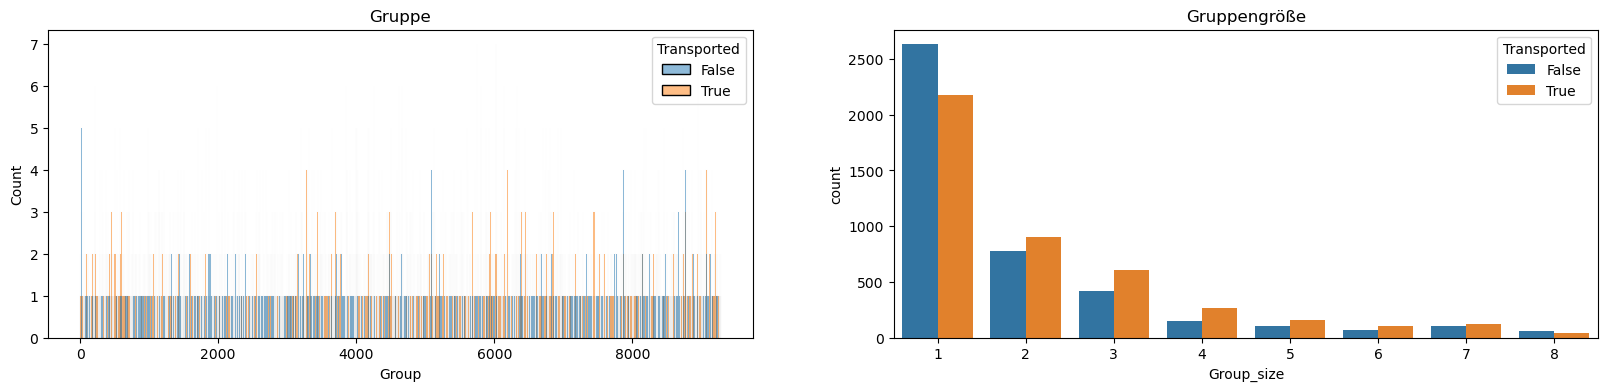

In [22]:
# Neue features - Gruppe
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# Neue features - Gruppengröße
train['Group_size']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

# neue Features Plotten
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Gruppe')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Gruppengröße')
fig.tight_layout()

Das Feature "Gruppe" wird nur zur Übersichtlichkeit angezeigt. Es hat zu viele verschiedene Werte, sodass wir es später wieder verwerfen werden. Stattdessen wird noch ein Feature aus der Gruppengröße abgeleitet. Dieses gibt an ob eine person allein reist oder nicht.

(0.0, 3000.0)

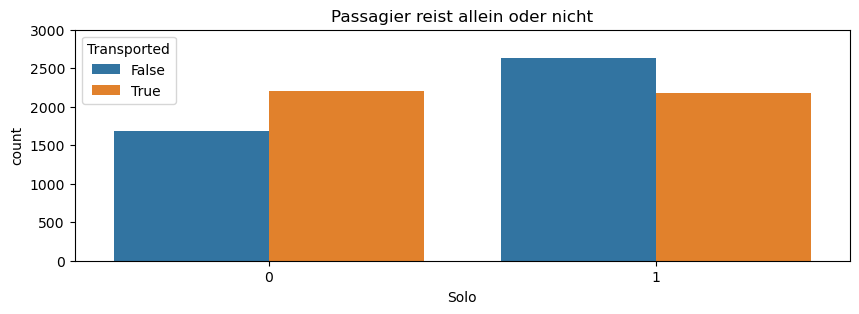

In [23]:
# Neues Feature
train['Solo']=(train['Group_size']==1).astype(int)
test['Solo']=(test['Group_size']==1).astype(int)

# Plot: Verteilung 
plt.figure(figsize=(10,3))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Passagier reist allein oder nicht')
plt.ylim([0,3000])

## Wert Kabine aufteilen
Die Spalte Kabine wird nun separiert und in Deck, Number und Side aufgeteilt. Später wird der Wert der Kabine verworfen.

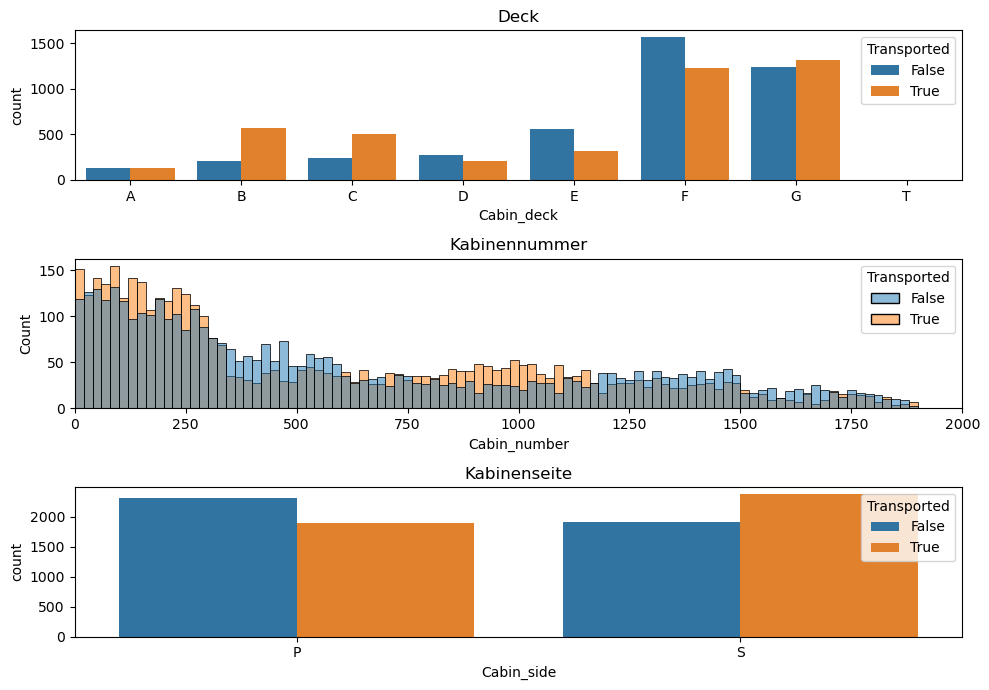

In [24]:
# Damit das Splitten funktioniert müssen die Missing Values (NaN) durch Platzhalter ersetzt werden
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

# Trainingsdaten
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# Testdaten
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Die Platzhalter wieder durch NaNs ersetzen
train.loc[train['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train.loc[train['Cabin_number']==9999, 'Cabin_number']=np.nan
train.loc[train['Cabin_side']=='Z', 'Cabin_side']=np.nan
test.loc[test['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test.loc[test['Cabin_number']==9999, 'Cabin_number']=np.nan
test.loc[test['Cabin_side']=='Z', 'Cabin_side']=np.nan



# Plots der neuen Features
fig=plt.figure(figsize=(10,7))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.title('Kabinennummer')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Kabinenseite')
fig.tight_layout()


Es ist auffällig, dass die Zielvariable teilweise einen Zusammenhang mit der Cabin_number hat. Immer Bereichsweise wechselt ob "transportiert" oder "nicht transportiert" überwiegt. Deshalb wird die Cabin_number in 7 bereiche von jeweils 300 Nummern aufgeteilt.

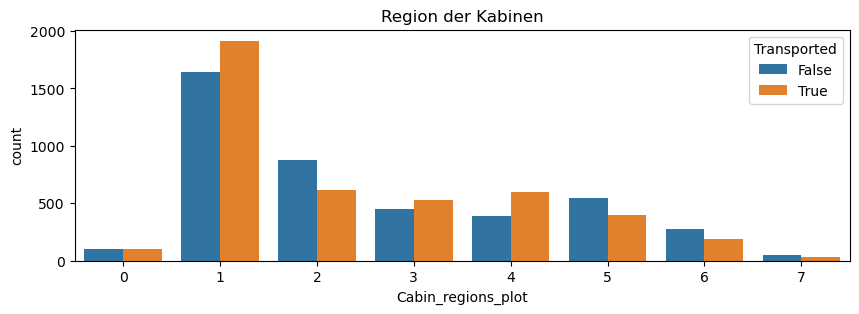

In [25]:
# Trainingsdaten
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)

# Testdaten
test['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=(test['Cabin_number']>=1800).astype(int)

# Plot
plt.figure(figsize=(10,3))
train['Cabin_regions_plot']=(train['Cabin_region1']+2*train['Cabin_region2']+3*train['Cabin_region3']+4*train['Cabin_region4']+5*train['Cabin_region5']+6*train['Cabin_region6']+7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Region der Kabinen')
train.drop('Cabin_regions_plot', axis=1, inplace=True)

### Cabin und Cabin_Number verwerfen
Die Variable Cabin wurde nun erfolgreich gesplittet und kann verworfen werden. 
Cabin_Number wird ebenso verworfen, da es zu viele verschiede Werte gibt und in meinen Augen keinen Mehrwert bietet.

In [26]:
# Die Spalte Cabin kann nun verworfen werden. Cabin_Number verwerfen wir ebenso wieder
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

### Name verwerfen
Die Spalte Name wird komplett verworfen. Man könnte sich noch überlegen nach gleichen Nachnamen zu suchen um daraus etwas abzuleiten (gleiche Familie). Hier kürzen wir aber etwas ab, da ich denke, dass es wenig Einfluss haben wird.

In [27]:
# Name verwerfen
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)



# Mising Values

Nun werden die Missing Values aufgefüllt. Hierfür combinieren wir die Trainings und Testdaten, da der Schritt ohnehin bei beiden Datensätzen durchgeführt werden muss.

In [28]:
# Daten wegspeichern vor droppen
y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()

# Test und Trainingsdaten zusammenfügen
data=pd.concat([X, test], axis=0).reset_index(drop=True)

In [29]:
# Spalten mit Missing Values
na_cols=data.columns[data.isna().any()].tolist()

# Zusammenfassung Missing Values
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


Text(0.5, 1.0, 'Heatmap von Missing Values (Test + Trainingsdaten)')

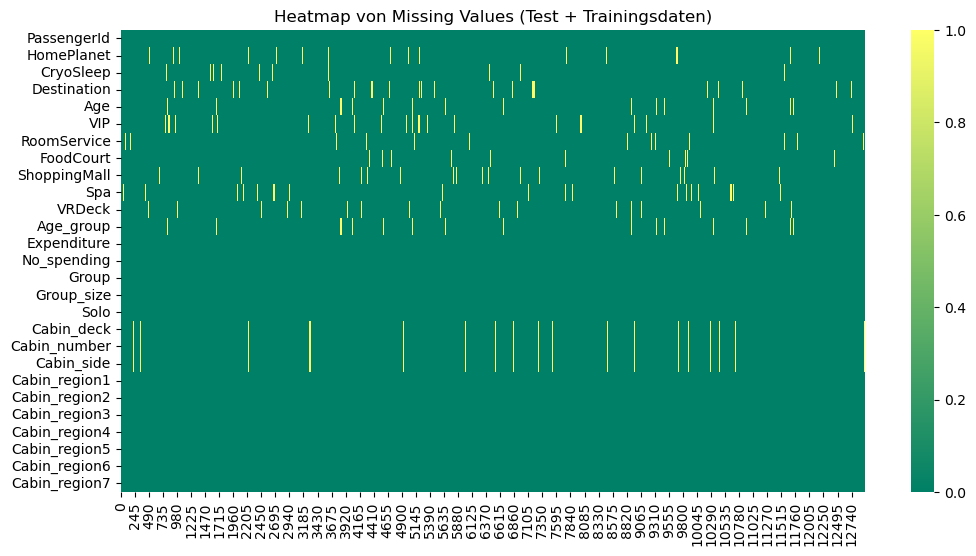

In [30]:
# Heatmap von missing values
plt.figure(figsize=(12,6))
sns.heatmap(data.isna().T, cmap='summer')
plt.title('Heatmap von Missing Values (Test + Trainingsdaten)')

Um möglichst viele MissingValues zu füllen und die Genauigkeit der Modelle dadurch eventuell zu maximieren, müsste man hier jetzt die Daten ganz genau analysieren indem man die verschiedenen Merkmale anschaut und Korrelationen sucht. So könnte man schauen ob Passagiere vom selben Heimatsplanet oder der selben Gruppe im selben Deck untergebrach sind. Da bei diesem Projekt aber nicht die Datenaufbereitung im Vordergrund steht, gehen wir hier den etwas einfacheren Weg und füllen die MissingValues teilweise mit vereinfachen annahmen. (Manche Modelle können mit MissingValues umgehen, manche aber auch nicht)

## HomePlanet MissingValues

Anzahl der verschiedenen HomePlanets pro Personengruppe ermitteln und zählen,
aus wie viel verschiedenen Heimatsplaneten die Gruppenmitglieder innerhalb einer Gruppe kommen.

In [31]:
# Erstelle Matrix wo die Anzahl der jeweiligen HomePlanets der Group zugeornet werden
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()


HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


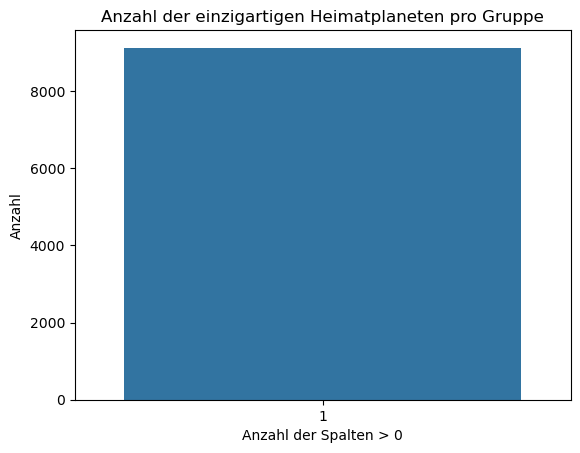

In [32]:
# Zähle die Anzahl der Werte pro Gruppe die Höher als 0 sind
count = (GHP_gb > 0).sum(axis=1)
value_counts = count.value_counts().sort_index()

# Plotten:
sns.countplot(x=count)
plt.xlabel('Anzahl der Spalten > 0')
plt.ylabel('Anzahl')
plt.title('Anzahl der einzigartigen Heimatplaneten pro Gruppe')
plt.xticks(range(len(value_counts)), value_counts.index)
plt.show()


Die Grafik zeigt, dass es keine Gruppe gibt, in welcher die Leute aus verschiedenen HomePlanets kommen. 
Deshalb kann man davon ausgehen, dass die Passagiere welche in einer Gruppe reisen, den gleichen HomePlanet wie die Gruppenangehörigen haben. Mit dieser Information können wir die MissingValues auffüllen

In [33]:
# Missing values vor dem auffüllen
HP_bef=data['HomePlanet'].isna().sum()

# Passagiere mit fehlendem HomePlanet und in einer Gruppe mit bekanntem HomePlanet
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Missing Values auffüllen
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Ausgabe wie viele MissingValues übrig sind
print('#HomePlanet missing values davor:',HP_bef)
print('#HomePlanet missing values danach:',data['HomePlanet'].isna().sum())

#HomePlanet missing values davor: 288
#HomePlanet missing values danach: 157


Das selbe könnte man im Zusammenhang mit Destination und Surename oder anderen Features auch noch machen. Diesen Aufwand sparen wir uns und füllen die fehlenden werte mit 'Missing'

In [34]:
HP_bef=data['HomePlanet'].isna().sum()
data["HomePlanet"].fillna('Missing', inplace=True)

# Ausgabe wie viele MissingValues übrig sind
print('#HomePlanet missing values davor:',HP_bef)
print('#HomePlanet missing values danach:',data['HomePlanet'].isna().sum())

#HomePlanet missing values davor: 157
#HomePlanet missing values danach: 0


## CryoSleep MissingValues
Hier fällt eine starke Korrelation mit dem Feature No_Spending auf. Alle Leute die etwas ausgegeben haben waren nicht in Kryoschlaf. Während die meisten, die gar nichts ausgegeben haben, in Kryoschlaf versetzt waren.


In [35]:
# Zusammenhänge in Matrix
data.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_spending,,
0,7339.0,0.0
1,740.0,4581.0


Mit dem Modus (das was am häufigsten vorkommt) die MissingValues füllen. 
Also alle die was Ausgegeben haben, bekommen CryoSleep = False und alle die nichts ausgegeben haben bekommen CrySleep = True

In [36]:
# Missing Values davor
CSL_bef=data['CryoSleep'].isna().sum()

# Missing Values mit dem Modus (am häufigst vorkommenden) auffüllen
na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
data.loc[data['CryoSleep'].isna(),'CryoSleep']=data.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

# Ausgabe wie viele MissingValues übrig sind
print('#CryoSleep missing values davor:',CSL_bef)
print('#CryoSleep missing values danach:',data['CryoSleep'].isna().sum())

#CryoSleep missing values davor: 310
#CryoSleep missing values danach: 0


## Destination MissingValues


In [37]:
distribution = data['Destination'].value_counts(normalize=True) #Verteilung
print(distribution)

TRAPPIST-1e      0.698724
55 Cancri e      0.208018
PSO J318.5-22    0.093258
Name: Destination, dtype: float64


Da die Mehrheit (70 %) der Passagiere in Richtung TRAPPIST-1e unterwegs ist, nehmen wir für die Missing Values einfach diesen Wert (d. h. den Modus) an.

In [38]:
# Missing Values davor
D_bef=data['Destination'].isna().sum()

# Missing Values mit dem Modus (am häufigst vorkommenden) auffüllen
data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

# Ausgabe wie viele MissingValues übrig sind
print('#Destination missing values davor:',D_bef)
print('#Destination missing values danach:',data['Destination'].isna().sum())

#Destination missing values davor: 274
#Destination missing values danach: 0


## Age MissingValues
Hier wird der Median genommen.


In [39]:
print(f"Age auffüllen mit Median: {data['Age'].median()}")
(print(f"Das wäre der Mittelwert (nur zur Info): {data['Age'].mean()}"))

# Missing Values davor
A_bef=data['Age'].isna().sum()

# Missing Values mit dem Median (am häufigst vorkommenden) auffüllen
data['Age'].fillna(data['Age'].median(), inplace=True)

# Ausgabe wie viele MissingValues übrig sind
print('Age missing values davor:',A_bef)
print('Age missing values danach:',data['Age'].isna().sum())

Age auffüllen mit Median: 27.0
Das wäre der Mittelwert (nur zur Info): 28.771968503937007
Age missing values davor: 270
Age missing values danach: 0


In [40]:
# Age_Group Feature nochmal aktualisieren
data.loc[data['Age']<=12,'Age_group']='Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18),'Age_group']='Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group']='Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']='Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']='Age_31-50'
data.loc[data['Age']>50,'Age_group']='Age_51+'

## VIP MissingValues
VIP wird auch mit dem Modus aufgefüllt da 97% nicht VIP sind.

In [41]:
distribution = data['VIP'].value_counts(normalize=True)
print(distribution)

False    0.97846
True     0.02154
Name: VIP, dtype: float64


In [42]:
# Missing Values davor
V_bef=data['VIP'].isna().sum()

# Missing Values mit dem Median (am häufigst vorkommenden) auffüllen
data.loc[data['VIP'].isna(),'VIP']=False

# Ausgabe wie viele Missing Values übrig sind 
print('#VIP missing values before:',V_bef)
print('#VIP missing values after:',data['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


## RoomService, FoodCourt, ShoppingMall, Spa, VRDeck MissingValues
Hier gilt wieder der Zusammenhang mit CryoSleep. Leute die in Kryoschlaf waren haben alle nichts ausgegeben.

In [43]:
print('Maximaler Kostenaufwand für Passagiere im CryoSleep:',data.loc[data['CryoSleep']==True,exp_feats].sum(axis=1).max())

Maximaler Kostenaufwand für Passagiere im CryoSleep: 0.0


In [44]:
# Missing Values davor
E_bef=data[exp_feats].isna().sum().sum()

# Alle wo in Kyoschlaf waren haben nichts ausgegeben
for col in exp_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col]=0

# Ausgabe wie viele MissingValues übrig sind
print('#Expenditure missing values davor:',E_bef)
print('#Expenditure missing values danach:',data[exp_feats].isna().sum().sum())

#Expenditure missing values davor: 1410
#Expenditure missing values danach: 866


Die restlichen Werte werden mit dem Median gefüllt. Hierfür nehmen wir den Median der entsprechenden Gruppe mit gleicher Altersklasse, gleicher Herkunft und der Info ob die Person alleinreisend ist. 

In [45]:
# Verteilung anzeigen
data.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   724.902222   788.150190   747.041152   736.655773   
           1          0.0   699.373333   782.845435   778.891200   793.188852   
Europa     0          0.0  1153.160256  2652.013298  3707.870455  3894.112440   
           1          0.0     0.000000  2523.264463  3846.376518  3912.026266   
Mars       0          0.0  1176.839286  1198.426934  1176.386598  1143.671916   
           1          0.0  1722.603175  1079.641910  1078.157303  1115.873047   
Missing    0          0.0     0.000000     0.000000   936.000000     0.000000   
           1          0.0   437.571429   964.200000  1718.526316  1864.304348   

Age_group            Age_51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      830.694704  
Europa     0     3483.639004  
           1     4014.362416  
Mars       0     1345.419643  
           1     1090.140496  
Missing    0        0.000000  
           1      889.666667

In [46]:
# Missing Values davor
E_bef=data[exp_feats].isna().sum().sum()

# Verbleibende fehlende Werte mit Hilfe des Medians auffüllen
for col in exp_feats:
    na_rows=data.loc[data[col].isna(),col].index
    data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','Solo','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]
    
# Ausgabe wie viele MissingValues übrig sind
print('#Expenditure missing values davor:',E_bef)
print('#Expenditure missing values danach:',data[exp_feats].isna().sum().sum())

#Expenditure missing values davor: 866
#Expenditure missing values danach: 0


## Cabin_deck, Cabin_number, Cabin_side Missing Values

## Cabin_side
CabinSide füllen wir mit 'P', da wir davon ausgehen, dass die Verteilung ungefähr 50% zu 50% sein sollte. 

In [47]:
print('Verteilung')
distribution = data['Cabin_side'].value_counts(normalize=True)
print(distribution)
print('')


# Missing Values davor
S_bef=data['Cabin_side'].isna().sum().sum()

data['Cabin_side'] =data['Cabin_side'].fillna('P')

# Ausgabe wie viele MissingValues übrig sind
print('#Cabin_side missing values davor:',S_bef)
print('#Cabin_side missing values danach:',data['Cabin_side'].isna().sum().sum())

Verteilung
S    0.503591
P    0.496409
Name: Cabin_side, dtype: float64

#Cabin_side missing values davor: 299
#Cabin_side missing values danach: 0


## Cabin_deck
Cabin_deck füllen wir mit 'Missig'.

In [48]:
print('Verteilung')
distribution = data['Cabin_deck'].value_counts(normalize=True)
print(distribution)

print('')
# Missing Values davor
D_bef=data['Cabin_deck'].isna().sum().sum()

data['Cabin_deck'] =data['Cabin_deck'].fillna('Missing')

# Ausgabe wie viele MissingValues übrig sind
print('#Cabin_deck missing values davor:',D_bef)
print('#Cabin_deck missing values danach:',data['Cabin_deck'].isna().sum().sum())

Verteilung
F    0.334543
G    0.298398
E    0.104412
B    0.090048
C    0.086970
D    0.056823
A    0.027938
T    0.000868
Name: Cabin_deck, dtype: float64

#Cabin_deck missing values davor: 299
#Cabin_deck missing values danach: 0


## Cabin_number
Cabin_number füllen wir mit '0'.

In [49]:
print('Verteilung')
distribution = data['Cabin_number'].value_counts(normalize=True)
print(distribution)

print('')
# Missing Values davor
D_bef=data['Cabin_number'].isna().sum().sum()

data['Cabin_number'] =data['Cabin_number'].fillna('0')

# Ausgabe wie viele MissingValues übrig sind
print('#Cabin_number missing values davor:',D_bef)
print('#Cabin_number missing values danach:',data['Cabin_number'].isna().sum().sum())

Verteilung
82.0      0.002683
4.0       0.002210
56.0      0.002210
95.0      0.002131
31.0      0.002131
            ...   
1848.0    0.000079
1847.0    0.000079
1846.0    0.000079
1844.0    0.000079
1890.0    0.000079
Name: Cabin_number, Length: 1894, dtype: float64

#Cabin_number missing values davor: 299
#Cabin_number missing values danach: 0


### Nun sind keine Missing Values mehr übrig:

In [50]:
data.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Age_group        0
Expenditure      0
No_spending      0
Group            0
Group_size       0
Solo             0
Cabin_deck       0
Cabin_number     0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
dtype: int64

# Preprocessing

Nun werden die Trainings und Testdaten wieder gesplittet.

In [51]:
# Training und Test splitten
X=data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test=data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

Nun verwerfen wir alle Spalten die uns keinen Mehrwert mehr bringen, oder welche die nur benötigt wurden um MissingValues zu füllen. ('PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number')

In [52]:
# Spalten droppen
X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)

## Log Transformation:
Wir wenden die Log Transformation auf die Ausgaben an und schauen ob die Daten danach mehr die Form einer Normalverteilung annehmen. Das verbessert oftmals die Leistung der Modelle.

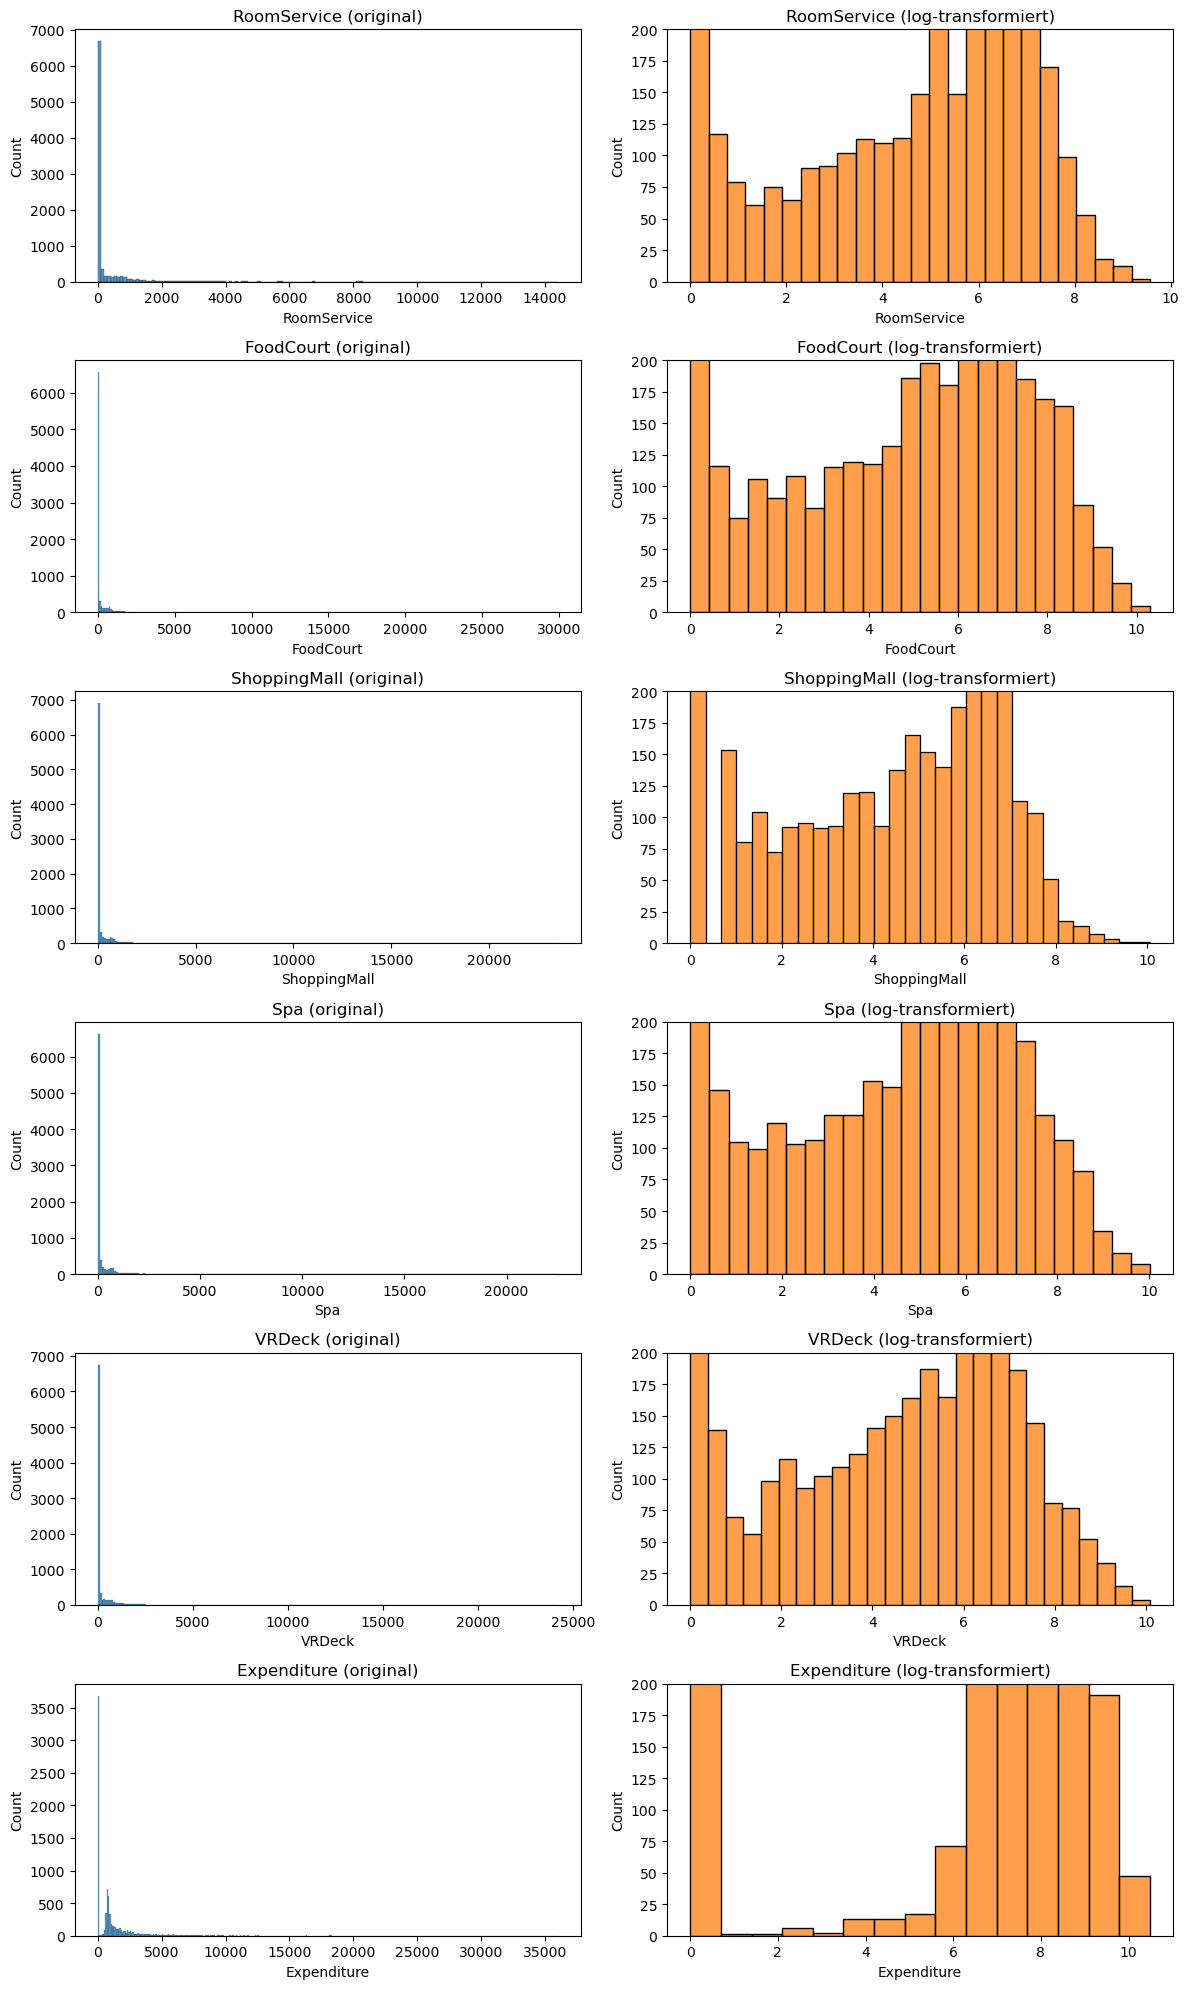

In [53]:
# Ergebnisse der Log-Transformation plotten
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    #plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transformiert)')
    
fig.tight_layout()
plt.show()

In [54]:
# Log-Transformation anwenden
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])

### Daten Normalisieren
Die Daten werden nun Normalisiert, damit die Modelle besser mit ihnen arbeiten können. Auf Kategorische Merkmale wird One-Hot Encoding angewendet und die nummerischen Merkmale werden so skaliert, dass der Mittelwert=0 und die Varianz=1 ist.
Nach der Anwendung besitzen wir nun 32 Merkmale)

In [55]:
# Aufteilen in nummerische und kategorische Spalten
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Numerische Daten so skalieren, dass der Mittelwert=0 und die Varianz=1 ist
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encodng kategorische Daten
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output=False))])

# Kombiniere beide transformer
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Transformer Anwenden
X = ct.fit_transform(X) #fit-Schritt lernt die Parameter (z. B. den Mittelwert und die Standardabweichung für das Skalieren)
X_test = ct.transform(X_test) #parameter nicht nochmal neu lernen deshalb nur transform

# Ausgabe neue Form (Zeilen, Spalten)
print('Trainingsdatensatz Form:', X.shape)
print('Testdatensatz Form:', X_test.shape)

Trainingsdatensatz Form: (8693, 32)
Testdatensatz Form: (4277, 32)


In [56]:
print(ct.get_feature_names_out())

['num__Age' 'num__RoomService' 'num__FoodCourt' 'num__ShoppingMall'
 'num__Spa' 'num__VRDeck' 'num__Expenditure' 'num__No_spending'
 'num__Solo' 'num__Cabin_region1' 'num__Cabin_region2'
 'num__Cabin_region3' 'num__Cabin_region4' 'num__Cabin_region5'
 'num__Cabin_region6' 'num__Cabin_region7' 'cat__HomePlanet_Europa'
 'cat__HomePlanet_Mars' 'cat__HomePlanet_Missing' 'cat__CryoSleep_True'
 'cat__Destination_PSO J318.5-22' 'cat__Destination_TRAPPIST-1e'
 'cat__VIP_True' 'cat__Cabin_deck_B' 'cat__Cabin_deck_C'
 'cat__Cabin_deck_D' 'cat__Cabin_deck_E' 'cat__Cabin_deck_F'
 'cat__Cabin_deck_G' 'cat__Cabin_deck_Missing' 'cat__Cabin_deck_T'
 'cat__Cabin_side_S']


### Aufteilen der Daten in Trainings und Validierungsdaten
75% Training, 25% Validierung

In [57]:
# Splitten in Trainings und Validierungsdaten 75% Training 25% Validierung
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.75,test_size=0.25,random_state=0)

# Modelle
Es werden folgende Trainingsmodelle benutzt:

- Logistic Regression
- KNN
- DecisionTree (CART)
- RandomForest
- XG-Boost
- SVM/SVC (SVC = Support Vektor Classifikation)
- Neuronale Netze





In [58]:
# Classifiers
# random state = 0 wird verwendet, um die Reproduzierbarkeit der Ergebnisse sicherzustellen. 
#Durch Festlegen des Wertes auf 0 werden die Zufallszahlen bei der Initialisierung des Modells 
#immer gleich generiert, so dass die Ergebnisse bei jedem Ausführen des Codes konsistent sind.


classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(random_state=0),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0), 
    "SVM" : SVC(random_state=0, probability=True),
    "NeuralNetwork" : MLPClassifier(random_state=0)
}


In [59]:
# Raster für die Rastersuche
LR_grid = { 'penalty': ['l1', 'l2'],
            'C': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 10.0],
            'solver': ['liblinear'],
            'max_iter': [50, 100, 200, 300]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9, 13],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]}

DT_grid = {'criterion': ['gini', 'entropy'],
           'max_depth': [None, 5, 10, 15, 20],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4],
           'max_features': [None, 'sqrt', 'log2']}

RF_grid = {'n_estimators': [50, 100, 200, 300],
           'criterion': ['gini', 'entropy'],
           'max_depth': [None, 5, 10, 15, 20],
           'min_samples_split': [2, 5, 10, 15],
           'min_samples_leaf': [1, 2, 4],
           'max_features': [None, 'sqrt', 'log2']}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
                'max_depth': [4, 8, 12],
                'learning_rate': [0.05, 0.1, 0.15],
                'subsample': [0.8, 0.9, 1.0]}

SVM_grid = {'C': [0.1, 0.5, 1, 2, 5, 8],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

NN_grid = { 'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'lbfgs'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': [200, 500, 1000]
}


# Zusammenfassun der Raster
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "DecisionTree" : DT_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "SVM" : SVM_grid,
    "NeuralNetwork" : NN_grid
}

## Trainieren und Auswerten der Modelle

Hier wird noch keine Crossvalidation erwendet da das sehr lange geht. Wir wollen erstmal nur eine grobe Idee für die besten Modelle für diesen Datensatz bekommen. (Wobei CV = None einem defaultwert von 5 folds entspricht)

In [60]:
#Während des Trainings durchläuft GridSearchCV systematisch alle möglichen Hyperparameterkombinationen, 
#trainiert das Modell für jede Kombination und bewertet es mithilfe der angegebenen Kreuzvalidierungsmethode. 
#Am Ende werden die besten Hyperparameter ermittelt, und das Modell wird mit den besten Hyperparametern erneut auf allen Trainingsdaten trainiert.

i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Trainingszeit': np.zeros(len(classifiers)), 'Genauigkeit': np.zeros(len(classifiers)), 'Precision': np.zeros(len(classifiers)), 'Recall': np.zeros(len(classifiers)), 'F1-Score': np.zeros(len(classifiers)), 'AUC-ROC': np.zeros(len(classifiers)), 'Best CV Score (Accuracy)': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None) #scoring='accuracy', ist bei Klassifikationsproblemen eig standard
    
    # Trainieren und Validieren
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,7]=clf.best_score_ # Score nach der Kreuzvalidierung
    #valid_scores.iloc[i,1]=clf.score(X_valid, y_valid) # Score auf Validierungsdaten (wird automatisch gewählt. Bei Klassifikationsproblemen ist es aber meistens die Genauigkeit)
    
    # Trainiertes Modell speichern
    clf_best_params[key]=clf.best_params_
    
    # Berechnen zusätzlicher Klassifizierungsmetriken
    valid_scores.iloc[i,2]=accuracy_score(y_valid, clf.predict(X_valid))
    valid_scores.iloc[i,3]=precision_score(y_valid, clf.predict(X_valid))
    valid_scores.iloc[i,4]=recall_score(y_valid, clf.predict(X_valid))
    valid_scores.iloc[i,5]=f1_score(y_valid, clf.predict(X_valid))
    valid_scores.iloc[i,6]=roc_auc_score(y_valid, clf.predict_proba(X_valid)[:,1])

    
    # Iteration und Trainingszeit anzeigen
    stop = time.time()
    valid_scores.iloc[i,1]=np.round((stop - start)/60, 2)
    print('Model:', key)
    print('Trainingszeit (mins):', valid_scores.iloc[i,1])
    print('')
    i+=1

Model: LogisticRegression
Trainingszeit (mins): 0.23

Model: KNN
Trainingszeit (mins): 0.19

Model: DecisionTree
Trainingszeit (mins): 0.16

Model: RandomForest
Trainingszeit (mins): 83.9

Model: XGBoost
Trainingszeit (mins): 8.02

Model: SVM
Trainingszeit (mins): 7.03



/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Model: NeuralNetwork
Trainingszeit (mins): 148.53



/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [61]:
# Zeige Ergebnisse
valid_scores

,Classifer,Trainingszeit,Genauigkeit,Precision,Recall,F1-Score,AUC-ROC,Best CV Score (Accuracy)
0,LogisticRegression,0.23,0.780589,0.771053,0.802740,0.786577,0.863568,0.777114
1,KNN,0.19,0.752990,0.775148,0.717808,0.745377,0.837131,0.786166
2,DecisionTree,0.16,0.760810,0.765466,0.757078,0.761249,0.841192,0.786627
3,RandomForest,83.90,0.792088,0.806482,0.772603,0.789179,0.884193,0.816692
4,XGBoost,8.02,0.797148,0.808491,0.782648,0.795360,0.887901,0.815157
5,SVM,7.03,0.798528,0.787402,0.821918,0.804290,0.879927,0.805187
6,NeuralNetwork,148.53,0.782889,0.806293,0.748858,0.776515,0.880528,0.806414


In [62]:
# Beste Parameter aus der Rastersuche anzeigen
clf_best_params

{'LogisticRegression': {'C': 0.1,
  'max_iter': 50,
  'penalty': 'l2',
  'solver': 'liblinear'},
 'KNN': {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'},
 'DecisionTree': {'criterion': 'gini',
  'max_depth': 10,
  'max_features': None,
  'min_samples_leaf': 2,
  'min_samples_split': 10},
 'RandomForest': {'criterion': 'entropy',
  'max_depth': 15,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 200},
 'XGBoost': {'learning_rate': 0.15,
  'max_depth': 8,
  'n_estimators': 50,
  'subsample': 0.8},
 'SVM': {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'},
 'NeuralNetwork': {'activation': 'relu',
  'alpha': 0.0001,
  'hidden_layer_sizes': (50,),
  'learning_rate': 'constant',
  'max_iter': 200,
  'solver': 'adam'}}

# Vergleich mit Optuna

Jedes Modell extra trainieren wegen langer Trainingszeit

In [63]:
# DataFrame für die kombinierten Ergebnisse erstellen
combined_results = pd.DataFrame()

### LogisticRegression Optuna

In [64]:
import optuna
from sklearn.model_selection import cross_val_score

# Funktion zum Optimieren der Hyperparameter mit optuna
def objective(trial):
    # Hyperparameter ausprobieren
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01, 10.0)
    solver = trial.suggest_categorical('solver', ['liblinear'])
    max_iter = trial.suggest_int('max_iter', 30, 300)
    
    # Modell erstellen und trainieren
    model = LogisticRegression(random_state=0, penalty=penalty, C=C, solver=solver, max_iter=max_iter)
    
    # Kreuzvalidierung mit 10 Folds durchführen
    scores = cross_val_score(model, X_train, y_train, cv=10)
    
    # Durchschnittliche Genauigkeit berechnen
    accuracy = scores.mean()
    
    # Rückgabe des zu optimierenden Ziels (in diesem Fall die durchschnittliche Genauigkeit)
    return accuracy

start = time.time()

# Optimierung mit optuna durchführen
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_CV_Score = study.best_value
    
# Beste Hyperparameter erhalten
best_params = study.best_params    
       
# Modell mit den besten Hyperparametern erstellen und trainieren
best_model = LogisticRegression(random_state=0, **best_params)
best_model.fit(X_train, y_train)  

# Vorhersagen auf Validierungsdaten machen
y_pred = best_model.predict(X_valid)
    
# Trainingszeit stoppen
stop = time.time()
trainingtime = np.round((stop - start)/60, 2)
    
      
# Metriken berechnen
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
auc_roc = roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:, 1])

# Ergebnisse in DataFrame-Tabelle speichern
results = pd.DataFrame({'Classifier': ['LogisticRegression'],
                       'Trainingszeit (mins)': [trainingtime],
                       'Genauigkeit': [accuracy],
                       'Precision': [precision],
                       'Recall': [recall],
                       'F1-Score': [f1],
                       'AUC-ROC': [auc_roc],
                       'Best CV score (Accuracy)': [best_CV_Score]})




[I 2023-07-07 10:25:57,400] A new study created in memory with name: no-name-aee1034a-0aca-4f1d-816c-8961e672a21f
[I 2023-07-07 10:25:58,864] Trial 0 finished with value: 0.7737404936247209 and parameters: {'penalty': 'l2', 'C': 3.364926868188924, 'solver': 'liblinear', 'max_iter': 193}. Best is trial 0 with value: 0.7737404936247209.
[I 2023-07-07 10:26:01,320] Trial 1 finished with value: 0.7748145844524235 and parameters: {'penalty': 'l1', 'C': 1.188149338998824, 'solver': 'liblinear', 'max_iter': 250}. Best is trial 1 with value: 0.7748145844524235.
[I 2023-07-07 10:26:02,837] Trial 2 finished with value: 0.7738938678578496 and parameters: {'penalty': 'l2', 'C': 2.9238636676668963, 'solver': 'liblinear', 'max_iter': 141}. Best is trial 1 with value: 0.7748145844524235.
[I 2023-07-07 10:26:05,758] Trial 3 finished with value: 0.7740472420909785 and parameters: {'penalty': 'l1', 'C': 2.613943912031677, 'solver': 'liblinear', 'max_iter': 245}. Best is trial 1 with value: 0.77481458445

In [65]:
# Ergebnisse anzeigen
print("Ergebnisse mit Optuna:")
display(results)
combined_results = pd.concat([combined_results, pd.DataFrame(results)], axis=0)


# Beste Parameter anzeigen
print("\nBeste Hyperparameter:")
for key, params in best_params.items():
    print(key, ":", params)

Ergebnisse mit Optuna:


,Classifier,Trainingszeit (mins),Genauigkeit,Precision,Recall,F1-Score,AUC-ROC,Best CV score (Accuracy)
0,LogisticRegression,2.52,0.779669,0.772085,0.798174,0.784912,0.861277,0.778648



Beste Hyperparameter:
penalty : l2
C : 0.016745788787617982
solver : liblinear
max_iter : 166


### KNN Optuna

In [66]:

# Funktion zum Optimieren der Hyperparameter mit optuna
def objective(trial):
    # Hyperparameter ausprobieren
    n_neighbors = trial.suggest_int("n_neighbors", 3, 15)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_categorical("p", [1, 2])
    
    # Modell erstellen und trainieren
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    
    # Kreuzvalidierung mit 10 Folds durchführen
    scores = cross_val_score(model, X_train, y_train, cv=10)
    
    # Durchschnittliche Genauigkeit berechnen
    accuracy = scores.mean()
    
    # Rückgabe des zu optimierenden Ziels (in diesem Fall die durchschnittliche Genauigkeit)
    return accuracy

start = time.time()

# Optimierung mit optuna durchführen
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_CV_Score = study.best_value
    
# Beste Hyperparameter erhalten
best_params = study.best_params    
       
# Modell mit den besten Hyperparametern erstellen und trainieren
best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train, y_train)  

# Vorhersagen auf Validierungsdaten machen
y_pred = best_model.predict(X_valid)
    
# Trainingszeit stoppen
stop = time.time()
trainingtime = np.round((stop - start)/60, 2)
    
      
# Metriken berechnen
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
auc_roc = roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:, 1])

# Ergebnisse in DataFrame-Tabelle speichern
results = pd.DataFrame({'Classifier': ['KNN'],
                       'Trainingszeit (mins)': [trainingtime],
                       'Genauigkeit': [accuracy],
                       'Precision': [precision],
                       'Recall': [recall],
                       'F1-Score': [f1],
                       'AUC-ROC': [auc_roc],
                       'Best CV score (Accuracy)': [best_CV_Score]})




[I 2023-07-07 10:28:28,463] A new study created in memory with name: no-name-766bab5b-9287-4ed9-850d-3dbadc85fbc2
[I 2023-07-07 10:28:29,642] Trial 0 finished with value: 0.7866276987739486 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.7866276987739486.
[I 2023-07-07 10:28:30,550] Trial 1 finished with value: 0.7594769255416396 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.7866276987739486.
[I 2023-07-07 10:28:31,465] Trial 2 finished with value: 0.7798778189288778 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.7866276987739486.
[I 2023-07-07 10:28:32,364] Trial 3 finished with value: 0.7626991980247473 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.7866276987739486.
[I 2023-07-07 10:28:32,791] Trial 4 finished with value: 0.7798775833309775 and parameters: {'n_neighbors': 5, 'weights': 

In [67]:
# Ergebnisse anzeigen
print("Ergebnisse mit Optuna:")
display(results)
combined_results = pd.concat([combined_results, pd.DataFrame(results)], axis=0)

# Beste Parameter anzeigen
print("\nBeste Hyperparameter:")
for key, params in best_params.items():
    print(key, ":", params)

Ergebnisse mit Optuna:


,Classifier,Trainingszeit (mins),Genauigkeit,Precision,Recall,F1-Score,AUC-ROC,Best CV score (Accuracy)
0,KNN,1.8,0.75299,0.775148,0.717808,0.745377,0.837131,0.786628



Beste Hyperparameter:
n_neighbors : 7
weights : uniform
p : 1


### DecisionTree Optuna

In [68]:

# Funktion zum Optimieren der Hyperparameter mit optuna
def objective(trial):
    # Hyperparameter ausprobieren    
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("max_depth", 1, 25)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2"])
    
    # Modell erstellen und trainieren
    model = DecisionTreeClassifier(random_state=0, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split,
                                            min_samples_leaf=min_samples_leaf, max_features=max_features)
    
    # Kreuzvalidierung mit 10 Folds durchführen
    scores = cross_val_score(model, X_train, y_train, cv=10)
    
    # Durchschnittliche Genauigkeit berechnen
    accuracy = scores.mean()
    
    # Rückgabe des zu optimierenden Ziels (in diesem Fall die durchschnittliche Genauigkeit)
    return accuracy

start = time.time()

# Optimierung mit optuna durchführen
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_CV_Score = study.best_value
    
# Beste Hyperparameter erhalten
best_params = study.best_params    
       
# Modell mit den besten Hyperparametern erstellen und trainieren
best_model = DecisionTreeClassifier(random_state=0, **best_params)
best_model.fit(X_train, y_train)  

# Vorhersagen auf Validierungsdaten machen
y_pred = best_model.predict(X_valid)
    
# Trainingszeit stoppen
stop = time.time()
trainingtime = np.round((stop - start)/60, 2)
    
      
# Metriken berechnen
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
auc_roc = roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:, 1])

# Ergebnisse in DataFrame-Tabelle speichern
results = pd.DataFrame({'Classifier': ['DecisionTree'],
                       'Trainingszeit (mins)': [trainingtime],
                       'Genauigkeit': [accuracy],
                       'Precision': [precision],
                       'Recall': [recall],
                       'F1-Score': [f1],
                       'AUC-ROC': [auc_roc],
                       'Best CV score (Accuracy)': [best_CV_Score]})




[I 2023-07-07 10:30:16,584] A new study created in memory with name: no-name-635a59b7-93e6-4e91-9d1d-1cb9c67882d7
[I 2023-07-07 10:30:16,680] Trial 0 finished with value: 0.7508825497347168 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7508825497347168.
[I 2023-07-07 10:30:17,097] Trial 1 finished with value: 0.7619276149010961 and parameters: {'criterion': 'gini', 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.7619276149010961.
[I 2023-07-07 10:30:17,172] Trial 2 finished with value: 0.7424441397378267 and parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.7619276149010961.
[I 2023-07-07 10:30:17,659] Trial 3 finished with value: 0.7676010479394607 and parameters: {'criterion': 'entropy', 'max_depth': 22, 'mi

In [69]:
# Ergebnisse anzeigen
print("Ergebnisse mit Optuna:")
display(results)
combined_results = pd.concat([combined_results, pd.DataFrame(results)], axis=0)

# Beste Parameter anzeigen
print("\nBeste Hyperparameter:")
for key, params in best_params.items():
    print(key, ":", params)

Ergebnisse mit Optuna:


,Classifier,Trainingszeit (mins),Genauigkeit,Precision,Recall,F1-Score,AUC-ROC,Best CV score (Accuracy)
0,DecisionTree,0.52,0.770929,0.797015,0.731507,0.762857,0.851835,0.788159



Beste Hyperparameter:
criterion : entropy
max_depth : 9
min_samples_split : 10
min_samples_leaf : 2
max_features : None


### RandomForest Optuna

In [70]:

# Funktion zum Optimieren der Hyperparameter mit optuna
def objective(trial):
    # Hyperparameter ausprobieren    
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("max_depth", 1, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 15)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2"])
        
    
    # Modell erstellen und trainieren
    model = RandomForestClassifier(random_state=0, n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                                            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                            max_features=max_features)
    
    # Kreuzvalidierung mit 10 Folds durchführen
    scores = cross_val_score(model, X_train, y_train, cv=10)
    
    # Durchschnittliche Genauigkeit berechnen
    accuracy = scores.mean()
    
    # Rückgabe des zu optimierenden Ziels (in diesem Fall die durchschnittliche Genauigkeit)
    return accuracy

start = time.time()

# Optimierung mit optuna durchführen
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_CV_Score = study.best_value
    
# Beste Hyperparameter erhalten
best_params = study.best_params    
       
# Modell mit den besten Hyperparametern erstellen und trainieren
best_model = RandomForestClassifier(random_state=0, **best_params)
best_model.fit(X_train, y_train)  

# Vorhersagen auf Validierungsdaten machen
y_pred = best_model.predict(X_valid)
    
# Trainingszeit stoppen
stop = time.time()
trainingtime = np.round((stop - start)/60, 2)
    
      
# Metriken berechnen
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
auc_roc = roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:, 1])

# Ergebnisse in DataFrame-Tabelle speichern
results = pd.DataFrame({'Classifier': ['RandomForest'],
                       'Trainingszeit (mins)': [trainingtime],
                       'Genauigkeit': [accuracy],
                       'Precision': [precision],
                       'Recall': [recall],
                       'F1-Score': [f1],
                       'AUC-ROC': [auc_roc],
                       'Best CV score (Accuracy)': [best_CV_Score]})




[I 2023-07-07 10:30:47,911] A new study created in memory with name: no-name-ccd3e7e7-86b7-48a7-a3dc-8ebf727f695f
[I 2023-07-07 10:30:54,917] Trial 0 finished with value: 0.8024231244051153 and parameters: {'n_estimators': 91, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8024231244051153.
[I 2023-07-07 10:31:48,817] Trial 1 finished with value: 0.8048806461036818 and parameters: {'n_estimators': 178, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.8048806461036818.
[I 2023-07-07 10:31:52,917] Trial 2 finished with value: 0.7358473985279843 and parameters: {'n_estimators': 87, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8048806461036818.
[I 2023-07-07 10:32:35,539] Trial 3 finished with value: 0.813316

In [71]:
# Ergebnisse anzeigen
print("Ergebnisse mit Optuna:")
display(results)
combined_results = pd.concat([combined_results, pd.DataFrame(results)], axis=0)

# Beste Parameter anzeigen
print("\nBeste Hyperparameter:")
for key, params in best_params.items():
    print(key, ":", params)

Ergebnisse mit Optuna:


,Classifier,Trainingszeit (mins),Genauigkeit,Precision,Recall,F1-Score,AUC-ROC,Best CV score (Accuracy)
0,RandomForest,57.04,0.787948,0.801905,0.76895,0.785082,0.883365,0.815925



Beste Hyperparameter:
n_estimators : 134
criterion : entropy
max_depth : 13
min_samples_split : 10
min_samples_leaf : 3
max_features : None


### XGBoost Optuna

In [72]:

# Funktion zum Optimieren der Hyperparameter mit optuna
def objective(trial):
    # Hyperparameter ausprobieren    
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 4, 20)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    subsample = trial.suggest_float("subsample", 0.8, 1.0)
                
    
    # Modell erstellen und trainieren
    model = XGBClassifier(random_state=0, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                          subsample=subsample)
    
    # Kreuzvalidierung mit 10 Folds durchführen
    scores = cross_val_score(model, X_train, y_train, cv=10)
    
    # Durchschnittliche Genauigkeit berechnen
    accuracy = scores.mean()
    
    # Rückgabe des zu optimierenden Ziels (in diesem Fall die durchschnittliche Genauigkeit)
    return accuracy

start = time.time()

# Optimierung mit optuna durchführen
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_CV_Score = study.best_value
    
# Beste Hyperparameter erhalten
best_params = study.best_params    
       
# Modell mit den besten Hyperparametern erstellen und trainieren
best_model = XGBClassifier(random_state=0, **best_params)
best_model.fit(X_train, y_train)  

# Vorhersagen auf Validierungsdaten machen
y_pred = best_model.predict(X_valid)
    
# Trainingszeit stoppen
stop = time.time()
trainingtime = np.round((stop - start)/60, 2)
    
      
# Metriken berechnen
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
auc_roc = roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:, 1])

# Ergebnisse in DataFrame-Tabelle speichern
results = pd.DataFrame({'Classifier': ['XGBoost'],
                       'Trainingszeit (mins)': [trainingtime],
                       'Genauigkeit': [accuracy],
                       'Precision': [precision],
                       'Recall': [recall],
                       'F1-Score': [f1],
                       'AUC-ROC': [auc_roc],
                       'Best CV score (Accuracy)': [best_CV_Score]})




[I 2023-07-07 11:27:50,242] A new study created in memory with name: no-name-ca4c4bcb-211e-4db2-95bd-abaef86039a6
[I 2023-07-07 11:28:11,757] Trial 0 finished with value: 0.8090231639855625 and parameters: {'n_estimators': 167, 'max_depth': 10, 'learning_rate': 0.13052968525624092, 'subsample': 0.9438447085559063}. Best is trial 0 with value: 0.8090231639855625.
[I 2023-07-07 11:28:32,304] Trial 1 finished with value: 0.8065684694618002 and parameters: {'n_estimators': 135, 'max_depth': 12, 'learning_rate': 0.13100412990498106, 'subsample': 0.8220806587404906}. Best is trial 0 with value: 0.8090231639855625.
[I 2023-07-07 11:28:37,555] Trial 2 finished with value: 0.811476444921923 and parameters: {'n_estimators': 84, 'max_depth': 4, 'learning_rate': 0.16187888832891414, 'subsample': 0.8664134261983856}. Best is trial 2 with value: 0.811476444921923.
[I 2023-07-07 11:28:55,779] Trial 3 finished with value: 0.8044207590021957 and parameters: {'n_estimators': 95, 'max_depth': 16, 'learni

In [73]:
# Ergebnisse anzeigen
print("Ergebnisse mit Optuna:")
display(results)
combined_results = pd.concat([combined_results, pd.DataFrame(results)], axis=0)

# Beste Parameter anzeigen
print("\nBeste Hyperparameter:")
for key, params in best_params.items():
    print(key, ":", params)

Ergebnisse mit Optuna:


,Classifier,Trainingszeit (mins),Genauigkeit,Precision,Recall,F1-Score,AUC-ROC,Best CV score (Accuracy)
0,XGBoost,17.97,0.799448,0.805375,0.793607,0.799448,0.896295,0.816539



Beste Hyperparameter:
n_estimators : 120
max_depth : 5
learning_rate : 0.18457124035024317
subsample : 0.866192064695367


### SVM Optuna

In [74]:

# Funktion zum Optimieren der Hyperparameter mit optuna
def objective(trial):
    # Hyperparameter ausprobieren    
    C = trial.suggest_float("C", 0.1, 8)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
        

    # Modell erstellen und trainieren
    model = SVC(random_state=0, probability=True, C=C, kernel=kernel, gamma=gamma)
    
    # Kreuzvalidierung mit 10 Folds durchführen
    scores = cross_val_score(model, X_train, y_train, cv=10)
    
    # Durchschnittliche Genauigkeit berechnen
    accuracy = scores.mean()
    
    # Rückgabe des zu optimierenden Ziels (in diesem Fall die durchschnittliche Genauigkeit)
    return accuracy

start = time.time()

# Optimierung mit optuna durchführen
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_CV_Score = study.best_value
    
# Beste Hyperparameter erhalten
best_params = study.best_params    
       
# Modell mit den besten Hyperparametern erstellen und trainieren
best_model = SVC(random_state=0, probability=True, **best_params)
best_model.fit(X_train, y_train)  

# Vorhersagen auf Validierungsdaten machen
y_pred = best_model.predict(X_valid)
    
# Trainingszeit stoppen
stop = time.time()
trainingtime = np.round((stop - start)/60, 2)
    
      
# Metriken berechnen
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
auc_roc = roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:, 1])

# Ergebnisse in DataFrame-Tabelle speichern
results = pd.DataFrame({'Classifier': ['SVM'],
                       'Trainingszeit (mins)': [trainingtime],
                       'Genauigkeit': [accuracy],
                       'Precision': [precision],
                       'Recall': [recall],
                       'F1-Score': [f1],
                       'AUC-ROC': [auc_roc],
                       'Best CV score (Accuracy)': [best_CV_Score]})




[I 2023-07-07 11:45:48,665] A new study created in memory with name: no-name-16d0b872-49b3-4e17-9346-f8544b40f100
[I 2023-07-07 11:47:00,050] Trial 0 finished with value: 0.7853978777341137 and parameters: {'C': 0.2003352983549893, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.7853978777341137.
[I 2023-07-07 11:48:07,410] Trial 1 finished with value: 0.7995094851714682 and parameters: {'C': 1.9406499700729771, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.7995094851714682.
[I 2023-07-07 11:49:18,588] Trial 2 finished with value: 0.802885367485605 and parameters: {'C': 7.483577092827436, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 2 with value: 0.802885367485605.
[I 2023-07-07 11:50:26,064] Trial 3 finished with value: 0.8039575735301046 and parameters: {'C': 2.575027149331839, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 3 with value: 0.8039575735301046.
[I 2023-07-07 11:51:36,061] Trial 4 finished with value: 0.8051862165804378 and parame

In [75]:
# Ergebnisse anzeigen
print("Ergebnisse mit Optuna:")
display(results)
combined_results = pd.concat([combined_results, pd.DataFrame(results)], axis=0)

# Beste Parameter anzeigen
print("\nBeste Hyperparameter:")
for key, params in best_params.items():
    print(key, ":", params)

Ergebnisse mit Optuna:


,Classifier,Trainingszeit (mins),Genauigkeit,Precision,Recall,F1-Score,AUC-ROC,Best CV score (Accuracy)
0,SVM,131.85,0.798988,0.786087,0.825571,0.805345,0.8798,0.807026



Beste Hyperparameter:
C : 4.044414053019822
kernel : rbf
gamma : auto


### NeuronalNetwork Optuna

In [76]:
# Funktion zum Optimieren der Hyperparameter mit optuna
def objective(trial):
    # Hyperparameter ausprobieren
    
    # Anzahl der Hidden-Layer
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3) # Anzahl der versteckten Schichten
    # Liste der Anzahl der Neuronen pro Layer
    hidden_layer_sizes = []
    for i in range(num_hidden_layers):
        num_neurons = trial.suggest_int(f'num_neurons_{i+1}', 1, 100)
        hidden_layer_sizes.append(num_neurons)
    
        
    activation = trial.suggest_categorical("activation", ["logistic", "tanh", "relu"])
    solver = trial.suggest_categorical("solver", ["adam", "lbfgs"])
    learning_rate = trial.suggest_categorical("learning_rate", ['constant', 'adaptive'])
    max_iter = trial.suggest_int("max_iter", 200, 1000)
    alpha = trial.suggest_float("alpha", 0.0001, 0.01)
                
    
    # Modell erstellen und trainieren
    model = MLPClassifier(random_state=0, hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver,
                          learning_rate =learning_rate, max_iter=max_iter, alpha=alpha)
    
    # Kreuzvalidierung mit 10 Folds durchführen
    scores = cross_val_score(model, X_train, y_train, cv=10)
    
    # Durchschnittliche Genauigkeit berechnen
    accuracy = scores.mean()
    
    # Rückgabe des zu optimierenden Ziels (in diesem Fall die durchschnittliche Genauigkeit)
    return accuracy

start = time.time()

# Optimierung mit optuna durchführen
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_CV_Score = study.best_value
    
# Beste Hyperparameter erhalten
best_params = study.best_params    
best_params['hidden_layer_sizes'] = []

num_hidden_layers = best_params['num_hidden_layers']
for i in range(num_hidden_layers):
    num_neurons = best_params[f'num_neurons_{i+1}']
    best_params['hidden_layer_sizes'].append(num_neurons)
    del best_params[f'num_neurons_{i+1}']

del best_params['num_hidden_layers']



       
# Modell mit den besten Hyperparametern erstellen und trainieren
best_model = MLPClassifier(random_state=0, **best_params)
best_model.fit(X_train, y_train)  

# Vorhersagen auf Validierungsdaten machen
y_pred = best_model.predict(X_valid)
    
# Trainingszeit stoppen
stop = time.time()
trainingtime = np.round((stop - start)/60, 2)
    
      
# Metriken berechnen
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
auc_roc = roc_auc_score(y_valid, best_model.predict_proba(X_valid)[:, 1])

# Ergebnisse in DataFrame-Tabelle speichern
results = pd.DataFrame({'Classifier': ['NeuronalNetwork'],
                       'Trainingszeit (mins)': [trainingtime],
                       'Genauigkeit': [accuracy],
                       'Precision': [precision],
                       'Recall': [recall],
                       'F1-Score': [f1],
                       'AUC-ROC': [auc_roc],
                       'Best CV score (Accuracy)': [best_CV_Score]})




[I 2023-07-07 13:57:39,916] A new study created in memory with name: no-name-d7ad7aff-c8f4-4fe7-b941-bed0a8e03392
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the

In [77]:
# Ergebnisse anzeigen
print("Ergebnisse mit Optuna:")
display(results)
combined_results = pd.concat([combined_results, pd.DataFBei solchen \acrame(results)], axis=0)

# Beste Parameter anzeigen
print("\nBeste Hyperparameter:")
for key, params in best_params.items():
    print(key, ":", params)

Ergebnisse mit Optuna:


,Classifier,Trainingszeit (mins),Genauigkeit,Precision,Recall,F1-Score,AUC-ROC,Best CV score (Accuracy)
0,NeuronalNetwork,226.28,0.778749,0.792381,0.759817,0.775758,0.874851,0.806721



Beste Hyperparameter:
activation : relu
solver : adam
learning_rate : constant
max_iter : 473
alpha : 0.0070323946424447215
hidden_layer_sizes : [9]


Zusammenfassung Ergebnisse mit Optuna

In [78]:
print("Kombinierte Ergebnisse:")
display(combined_results)

Kombinierte Ergebnisse:


,Classifier,Trainingszeit (mins),Genauigkeit,Precision,Recall,F1-Score,AUC-ROC,Best CV score (Accuracy)
0,LogisticRegression,2.52,0.779669,0.772085,0.798174,0.784912,0.861277,0.778648
0,KNN,1.80,0.752990,0.775148,0.717808,0.745377,0.837131,0.786628
0,DecisionTree,0.52,0.770929,0.797015,0.731507,0.762857,0.851835,0.788159
0,RandomForest,57.04,0.787948,0.801905,0.768950,0.785082,0.883365,0.815925
0,XGBoost,17.97,0.799448,0.805375,0.793607,0.799448,0.896295,0.816539
0,SVM,131.85,0.798988,0.786087,0.825571,0.805345,0.879800,0.807026
0,NeuronalNetwork,226.28,0.778749,0.792381,0.759817,0.775758,0.874851,0.806721


# Submission

Submission mit bestem Modell und besten Parametern

### 1. Submission LogisticRegression

In [3]:
params_LR_best= {   'penalty': 'l2',
                    'C': 0.1,
                    'solver': 'liblinear',
                    'max_iter': 50}

pred_LR_best = (LogisticRegression(random_state=0, **params_LR_best).fit(X,y)).predict(X_test)
submission['Transported'] = pred_LR_best
submission['Transported']=submission['Transported']>0.5
submission.to_csv('submission_LR.csv', index=False)

NameError: name 'LogisticRegression' is not defined

### 2. Submission KNN

In [ ]:
params_KNN_best= {  'n_neighbors': 7,
                    'weights': 'uniform',
                    'p': 1}

pred_KNN_best = (KNeighborsClassifier(**params_KNN_best).fit(X,y)).predict(X_test)
submission['Transported'] = pred_KNN_best
submission['Transported']=submission['Transported']>0.5
submission.to_csv('submission_KNN.csv', index=False)

### 3. DecisionTree

In [ ]:
params_DT_best= {'criterion': 'entropy',
                'max_depth': 9,
                'min_samples_split': 10,
                 'min_samples_leaf': 2
                'max_features': None}

pred_DT_best = (DecisionTreeClassifier(random_state=0, **params_DT_best).fit(X,y)).predict(X_test)
submission['Transported'] = pred_DT_best
submission['Transported']=submission['Transported']>0.5
submission.to_csv('submission_DT.csv', index=False)

### 4. Submission RandomForest

In [ ]:
params_RF_best= {  'n_estimators': 200,
                   'criterion': 'entropy',
                   'max_depth': 15,
                   'min_samples_split': 2,
                   'min_samples_leaf': 2,
                   'max_features': 'sqrt'}

pred_RF_best = (RandomForestClassifier(random_state=0, **params_RF_best).fit(X,y)).predict(X_test)
submission['Transported'] = pred_RF_best
submission['Transported']=submission['Transported']>0.5
submission.to_csv('submission_RF.csv', index=False)

### 5. Submission XG-Boost

In [79]:
params_XGB_best= {'n_estimators': 120,
                'max_depth': 5,
                'learning_rate': 0.18457124035024317,
                'subsample': 0.866192064695367}

pred_XGB_best = (XGBClassifier(random_state=0, **params_XGB_best).fit(X,y)).predict(X_test)
submission['Transported'] = pred_XGB_best
submission['Transported']=submission['Transported']>0.5
submission.to_csv('submission_xgb.csv', index=False)


### 6. Submission SVM

In [80]:
params_SVM_best= {'C': 4.044414053019822, 
             'kernel': 'rbf', 
             'gamma': 'auto'}

pred_SVM_best = (SVC(random_state=0, probability=True, **params_SVM_bests).fit(X,y)).predict(X_test)
submission['Transported'] = pred_SVM_best
submission['Transported']=sample['Transported']>0.5
submission.to_csv('submission_svm.csv', index=False)

NameError: name 'params_XGB_bests' is not defined

### 7. Submission NeuronalNetwork

In [ ]:
params_NN_best= {   'hidden_layer_sizes': (50,),
                    'activation': 'relu',
                    'solver': 'adam',
                    'alpha': 0.0001,
                    'learning_rate': 'constant',
                    'max_iter': 200}
}

pred_NN_best = (MLPClassifier(random_state=0, **params_NN_best).fit(X,y)).predict(X_test)
submission['Transported'] = pred_NN_best
submission['Transported']=submission['Transported']>0.5
submission.to_csv('submission_Neuronal.csv', index=False)